In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
import random

In [2]:
# Genereate network
def generate_network():
    random.seed(42)
    np.random.seed(42)
    G = nx.Graph()
    
    nodes = [f'g{i}' for i in range(1, 21)]
    G.add_nodes_from(nodes)
    
    for i in range(1, 6):
        node = f'g{i}'
        while len(list(G.neighbors(node))) < 10:
            target = random.choice(nodes)
            if target != node and not G.has_edge(node, target):
                weight = random.uniform(0, 1)
                G.add_edge(node, target, weight=weight)
    
    for i in range(6, 21):
        node = f'g{i}'
        num_edges = random.randint(0, 2)
        while len(list(G.neighbors(node))) < num_edges:
            target = random.choice(nodes)
            if target != node and not G.has_edge(node, target):
                weight = random.uniform(0, 1)
                G.add_edge(node, target, weight=weight)
    
    return G

network = generate_network()

In [3]:
# Generate adjacency matrix
def generate_edges(G):
    edges = list(G.edges())
    return edges

def generate_nodes(G):
    node_core_numbers = nx.core_number(G)
    return node_core_numbers

def generate_adj_matrix(G):
    edges = generate_edges(G)
    nodes = generate_nodes(G)
    
    adj_matrix = pd.DataFrame(0, index=nodes.keys(), columns=nodes.keys())
    for edge in edges:
        adj_matrix.loc[edge[0], edge[1]] = 1
        adj_matrix.loc[edge[1], edge[0]] = 1
    
    return adj_matrix

edges = generate_edges(network)
nodes = generate_nodes(network)
adj_matrix = generate_adj_matrix(network)

In [4]:
len(edges)

44

In [5]:
nodes

{'g1': 4,
 'g2': 4,
 'g3': 4,
 'g4': 4,
 'g5': 4,
 'g6': 2,
 'g7': 4,
 'g8': 4,
 'g9': 2,
 'g10': 1,
 'g11': 3,
 'g12': 2,
 'g13': 3,
 'g14': 1,
 'g15': 3,
 'g16': 1,
 'g17': 2,
 'g18': 4,
 'g19': 3,
 'g20': 2}

In [6]:
# Function to normalize based on degree
def normalize_by_degree(adj_matrix):
    degree = adj_matrix.sum(axis=1)
    degree[degree == 0] = 1  # Avoid division by zero
    W_degree = adj_matrix.values @ np.diag(1 / degree)
    W_degree_df = pd.DataFrame(W_degree, index=adj_matrix.index, columns=adj_matrix.columns)
    return W_degree_df.div(W_degree_df.sum(axis=0), axis=1)

# Function to normalize based on core
def normalize_by_core(adj_matrix, cores):
    core_values = np.array([cores[node] for node in adj_matrix.columns])
    W_core = np.zeros(adj_matrix.shape)
    for i in range(len(adj_matrix.columns)):
        neighbors = adj_matrix.iloc[:, i] != 0
        core_sum = core_values[neighbors].sum()
        if core_sum > 0:
            W_core[:, i] = core_values / core_sum * neighbors
    W_core_df = pd.DataFrame(W_core, index=adj_matrix.index, columns=adj_matrix.columns)
    return W_core_df.div(W_core_df.sum(axis=0), axis=1)

# Function to normalize based on degree-core difference
def normalize_by_diff(adj_matrix, cores):
    degree = adj_matrix.sum(axis=1)
    W_diff = np.zeros(adj_matrix.shape)
    for i, node in enumerate(adj_matrix.columns):
        neighbors = adj_matrix.iloc[:, i] != 0
        for j, neighbor in enumerate(adj_matrix.index):
            if neighbors[j]:
                diff = degree[node] - cores[node]
                if diff > 0:
                    W_diff[j, i] = adj_matrix.iloc[j, i] / diff
                else:
                    W_diff[j, i] = adj_matrix.iloc[j, i]
        column_sum = W_diff[:, i].sum()
        if column_sum > 0:
            W_diff[:, i] /= column_sum

    W_diff_df = pd.DataFrame(W_diff, index=adj_matrix.index, columns=adj_matrix.columns)
    return W_diff_df.div(W_diff_df.sum(axis=0), axis=1)

# Function to normalize based on degree/core ratio
def normalize_by_ratio(adj_matrix, cores):
    degree = adj_matrix.sum(axis=1)
    W_ratio = np.zeros(adj_matrix.shape)
    for i, node in enumerate(adj_matrix.columns):
        W_ratio[:, i] = (np.array(list(cores.values())) / degree[node]) * adj_matrix.iloc[:, i]
    W_ratio /= W_ratio.sum(axis=0)
    W_ratio_df = pd.DataFrame(W_ratio, index=adj_matrix.index, columns=adj_matrix.columns)
    return W_ratio_df.div(W_ratio_df.sum(axis=0), axis=1)

# Function to normalize
def normalize_adj_matrix(adj_matrix, cores, norm_method):
    if norm_method == 'degree':
        norm_adj_matrix = normalize_by_degree(adj_matrix)
    elif norm_method == 'core':
        norm_adj_matrix = normalize_by_core(adj_matrix, cores)
    elif norm_method == 'diff':
        norm_adj_matrix = normalize_by_diff(adj_matrix, cores)
    elif norm_method == 'ratio':
        norm_adj_matrix = normalize_by_ratio(adj_matrix, cores)
    else:
        raise ValueError("Invalid normalization method.")
    
    return norm_adj_matrix

In [7]:
norm_method = 'core'
norm_adj_matrix = normalize_adj_matrix(adj_matrix, nodes, norm_method)

In [8]:
norm_adj_matrix

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20
g1,0.000000,0.000000,0.121212,0.114286,0.129032,0.5,0.25,0.25,0.5,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.5,0.25,0.000000,0.0
g2,0.000000,0.000000,0.121212,0.114286,0.129032,0.0,0.25,0.00,0.0,1.0,0.333333,0.5,0.333333,0.0,0.333333,0.0,0.0,0.00,0.333333,0.5
g3,0.129032,0.121212,0.000000,0.114286,0.000000,0.5,0.25,0.25,0.0,0.0,0.000000,0.5,0.000000,0.0,0.333333,0.0,0.0,0.25,0.000000,0.5
g4,0.129032,0.121212,0.121212,0.000000,0.000000,0.0,0.25,0.25,0.5,0.0,0.333333,0.0,0.333333,0.0,0.000000,0.0,0.0,0.25,0.333333,0.0
g5,0.129032,0.121212,0.000000,0.000000,0.000000,0.0,0.00,0.25,0.0,0.0,0.333333,0.0,0.333333,0.0,0.333333,1.0,0.5,0.25,0.333333,0.0
g6,0.064516,0.000000,0.060606,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0
g7,0.129032,0.121212,0.121212,0.114286,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0
g8,0.129032,0.000000,0.121212,0.114286,0.129032,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0
g9,0.064516,0.000000,0.000000,0.057143,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0
g10,0.000000,0.030303,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0


In [9]:
# Disease related genes (seed genes)
seeds = ['g2', 'g4','g6','g8','g10']

# Function to run RWR
def rwr(norm_adj_matrix, seeds, alpha, max_iter=100, tol=1e-6):
    p0 = np.zeros(norm_adj_matrix.shape[0])
    seed_indices = [norm_adj_matrix.index.get_loc(seed) for seed in seeds]
    p0[seed_indices] = 1
    W = norm_adj_matrix.values
    n = W.shape[0]
    pk = p0.copy()
    for _ in range(max_iter):
        pk_new = alpha * p0 + (1 - alpha) * W @ pk
        if np.linalg.norm(pk_new - pk, 1) < tol:
            break
        pk = pk_new
    return pk

# Function to run random RWR
def random_rwr(network, seeds, alpha, n_random_networks=100):
    pks_random = []
    for _ in range(n_random_networks):
        G_random = network.copy()
        nx.double_edge_swap(G_random, nswap=len(G_random.edges()), max_tries=len(G_random.edges()) * 10)

        core_random = generate_nodes(G_random)
        adj_matrix_random = generate_adj_matrix(G_random)
        norm_adj_random = normalize_adj_matrix(adj_matrix_random, core_random, norm_method)
        
        pk_random = rwr(norm_adj_random, seeds, alpha, max_iter=100, tol=1e-6)
        pks_random.append(pk_random)

    pks_random = np.array(pks_random)
    return pks_random

# Function to calculate P-values for each node
def calculate_p_values(network, pk_original, pks_random):
    nodes = generate_nodes(network)
    p_values = []
    for i, node in enumerate(nodes):
        original_weight = pk_original[i]
        random_weights = pks_random[:, i]
        p_value = np.sum(random_weights >= original_weight) / pks_random.shape[0]
        p_values.append(p_value)
    return p_values

In [10]:
# Run RWR algorithm for α = 0.1
alpha = 0.1

pk = rwr(norm_adj_matrix, seeds, alpha=alpha)
pks_random = random_rwr(network, seeds, alpha=alpha)
p_values = calculate_p_values(network, pk, pks_random)
    
print(f"\nRWR Result (α = {alpha}):")
for node, score in zip(norm_adj_matrix.index, pk):
        print(f"{node}: {score:.4f}")
    
# Identify significantly re-ranked nodes
significance_level = 0.3
significant_nodes = [node for node, p_value in zip(norm_adj_matrix.index, p_values) if p_value < significance_level]
        
print(f"\nSignificantly re-ranked nodes (α = {alpha}):")
for node in significant_nodes:
    print(node)


RWR Result (α = 0.1):
g1: 0.5260
g2: 0.6989
g3: 0.5806
g4: 0.6608
g5: 0.4917
g6: 0.1622
g7: 0.2686
g8: 0.3495
g9: 0.0645
g10: 0.1191
g11: 0.1510
g12: 0.0698
g13: 0.1510
g14: 0.0153
g15: 0.1475
g16: 0.0143
g17: 0.0591
g18: 0.2495
g19: 0.1510
g20: 0.0698

Significantly re-ranked nodes (α = 0.1):
g3
g7
g12
g19


In [11]:
# Run RWR algorithm for α = 0.3, 0.5, 0.8
alphas = [0.3, 0.5, 0.8]
for alpha in alphas:
    pk = rwr(norm_adj_matrix, seeds, alpha=alpha)
    pks_random = random_rwr(network, seeds, alpha=alpha)
    p_values = calculate_p_values(network, pk, pks_random)
    
    print(f"\nRWR Result (α = {alpha}):")
    #for node, score in zip(norm_adj_matrix.index, pk):
    #    print(f"{node}: {score:.4f}")
    
    # Identify significantly re-ranked nodes
    significance_level = 0.3
    significant_nodes = [node for node, p_value in zip(norm_adj_matrix.index, p_values) if p_value < significance_level]
        
    print(f"\nSignificantly re-ranked nodes (α = {alpha}):")
    for node in significant_nodes:
        print(node)


RWR Result (α = 0.3):

Significantly re-ranked nodes (α = 0.3):
g7
g11
g12
g13
g19
g20

RWR Result (α = 0.5):

Significantly re-ranked nodes (α = 0.5):
g2
g3
g7
g11
g12
g13
g19
g20

RWR Result (α = 0.8):

Significantly re-ranked nodes (α = 0.8):
g2
g7
g11
g12
g19
g20


In [12]:
# Function to perform 5-fold cross-validation and calculate ROC curves for 4 normalization methods
def cross_validation_and_roc(network, disease_genes, alpha, n_splits=5):
    
    edges = generate_edges(network)
    nodes = generate_nodes(network)
    adj_matrix = generate_adj_matrix(network)

    norm_methods = ['degree', 'core', 'diff', 'ratio']
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    all_fpr = []
    all_tpr = []
    all_auroc = []

    for norm_method in norm_methods:
        norm_adj_matrix = normalize_adj_matrix(adj_matrix, nodes, norm_method=norm_method)
        
        tprs = []
        fprs = []
        aurocs = []
        
        for train_index, test_index in kf.split(disease_genes):
            train_genes = [disease_genes[i] for i in train_index]
            test_genes = [disease_genes[i] for i in test_index]
            
            p0 = np.zeros(len(norm_adj_matrix))
            p0[[norm_adj_matrix.index.get_loc(gene) for gene in train_genes]] = 1.0 / len(train_genes)
            
            pk = rwr(norm_adj_matrix, seeds, alpha=alpha, max_iter=100, tol=1e-6)
            
            pks_random = random_rwr(network, seeds, alpha=alpha, n_random_networks=100)
            
            p_values = calculate_p_values(network, pk, pks_random)
            
            y_true = np.isin(norm_adj_matrix.index, test_genes).astype(int)
            y_scores = -np.array(p_values)
            
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            interp_fpr = np.linspace(0, 1, 100)
            interp_tpr = interp1d(fpr, tpr, kind='linear')(interp_fpr)
            
            tprs.append(interp_tpr)
            fprs.append(interp_fpr)
            aurocs.append(auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_fpr = np.mean(fprs, axis=0)
        mean_auc = np.mean(aurocs)
        
        all_tpr.append(mean_tpr)
        all_fpr.append(mean_fpr)
        all_auroc.append(mean_auc)

        plt.plot(mean_fpr, mean_tpr, label=f'{norm_method} (AUC = {mean_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Different Normalization Methods')
    plt.legend()
    plt.show()
    
    return all_fpr, all_tpr, all_auroc

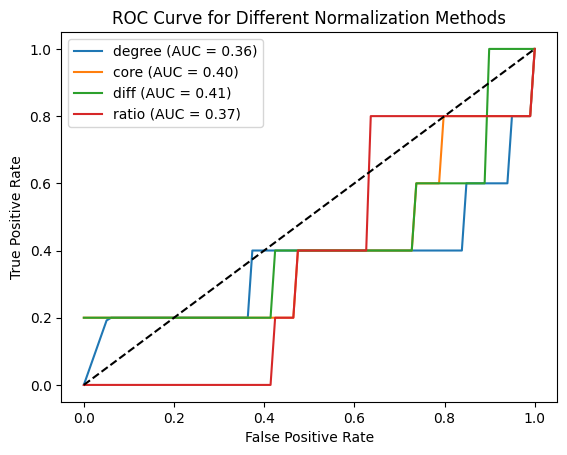

In [13]:
# Disease-related genes (seed genes)
seeds = ['g2', 'g4','g6','g8','g10']

# Perform cross-validation and plot ROC curves
all_fpr, all_tpr, all_auroc = cross_validation_and_roc(network, seeds, alpha=0.8)

In [14]:
# Display results
for norm_method, auroc in zip(['degree', 'core', 'diff', 'ratio'], all_auroc):
    print(f"{norm_method} normalization AUROC: {auroc:.4f}")

degree normalization AUROC: 0.3632
core normalization AUROC: 0.4000
diff normalization AUROC: 0.4105
ratio normalization AUROC: 0.3684


In [15]:
# Extension of seed modules using P-values and propagation weights
def identify_modules(network, seeds, norm_method, alpha, p_threshold, wmin_percentile):

    edges = generate_edges(network)
    nodes = generate_nodes(network)
    adj_matrix = generate_adj_matrix(network)
    norm_adj_matrix = normalize_adj_matrix(adj_matrix, nodes, norm_method)

    pk = rwr(norm_adj_matrix, seeds, alpha=alpha)
    pks_random = random_rwr(network, seeds, alpha=alpha, n_random_networks=100)
    p_values = calculate_p_values(network, pk, pks_random)
    
    # Step i: Extract seed-induced sub-network
    seed_subnetwork = network.subgraph(seeds).copy()
    
    # Step ii: Extend seed-induced sub-network
    extended_subnetwork = seed_subnetwork.copy()
    
    # Get propagation weights and significant nodes
    significant_nodes = [node for node, p_val in zip(network.nodes, p_values) if p_val < p_threshold]
    
    # Calculate wmin based on the 75th percentile of propagation weights of significant nodes
    if significant_nodes:
        propagation_weights = np.array([pk[list(network.nodes).index(node)] for node in significant_nodes])
        wmin = np.percentile(propagation_weights, wmin_percentile)
    else:
        wmin = 0
    
    # Add nodes to the extended sub-network
    for node in significant_nodes:
        if node not in seeds and pk[list(network.nodes).index(node)] > wmin:
            neighbors = set(network.neighbors(node))
            if neighbors & set(seeds):
                extended_subnetwork.add_node(node)
                for neighbor in neighbors:
                    if neighbor in seeds or neighbor in extended_subnetwork.nodes:
                        extended_subnetwork.add_edge(node, neighbor, weight=network.edges[node, neighbor]['weight'])
    
    # Step iii: Identify modules as connected components
    modules = [component for component in nx.connected_components(extended_subnetwork)]
    
    return modules

In [16]:
norm_method = 'core'

# Set disease genes as seed genes
seeds = ['g2', 'g4','g6','g8','g10']

# Identify modules
modules = identify_modules(network, seeds, norm_method, alpha = 0.8, p_threshold=0.3, wmin_percentile=75)

for i, module in enumerate(modules):
    print(f"Module {i+1}: {module}")

Module 1: {'g6'}
Module 2: {'g7', 'g4', 'g8', 'g10', 'g2'}


In [17]:
# Calculate the entropy of the seed nodes
def calculate_entropy(modules, seeds):
    n = len(seeds)
    k_m = [len(set(module) & set(seeds)) for module in modules]
    
    k_m += [1] * (n - sum(k_m))
    
    p_m = np.array(k_m) / n
    entropy = -np.sum(p_m * np.log(p_m))
    
    return entropy

# Compare to the maximum possible entropy
def evaluate_connectivity(modules, seeds):
    n = len(seeds)
    entropy = calculate_entropy(modules, seeds)
    max_entropy = np.log(n)
    connectivity = max_entropy - entropy
    
    return connectivity

# Evaluate the connectivity of the identified modules
connectivity = evaluate_connectivity(modules, seeds)
print(f"Connectivity: {connectivity}")

Connectivity: 1.1090354888959124
